In [1]:
#IMPORTED LIBRARIES
#requests is a library that allows us to make requests to APIS, this is essential for the project
#json is a library to modify the visual appearance of a json
#datetime is a library that contains time values, its use is mainly related to data access
#azurecosmos are libraries for connecting to the cosmos database in Azure, these allow us to access the database API to make queries
#os is a library that allows us to interact with the operating system where the program is executed
#uuid generate a unique UUID instead of using the current date and time. This ensures that each ID is unique.
#mpld3 export charts as HTML
#re process strings information
import json, requests, os
from json.decoder import JSONDecodeError
from datetime import datetime
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from collections import defaultdict
from datetime import datetime
from windows_tools.installed_software import get_installed_software
import matplotlib.pyplot as plt
import mpld3
import re

In [2]:
uri = "[INSERT_MONGO_DB_CONNECTION]"

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

#Vulnerabilities.PcSoftwareCVE
# Selecciona la base de datos que deseas usar
db = client['[DATABASE]']
# Selecciona la colección que deseas usar
collection = db['[CONTAINER]']

db = collection.find()

Pinged your deployment. You successfully connected to MongoDB!


In [3]:
data = []

# Iterar sobre los documentos en la colección y agregarlos a la lista
for document in collection.find():
    data.append(document)

#print(json.dumps(data[0].json(), indent=4))

In [4]:
def exportChartHTML(plt, html_content, fileName):
    # Crear la ruta completa al archivo HTML en la carpeta destino
    # Obtener la ruta completa al directorio de descargas
    downloads_dir = os.path.join('C:', os.sep, 'Users', '{USER}', 'Downloads')
    savePath = os.path.join(downloads_dir, fileName)

    # Escribir el contenido HTML en el archivo
    with open(savePath, 'w') as f:
        f.write(html_content)

    print(f"La gráfica ha sido guardada en: {savePath}")

In [5]:
def exportTopSWBarChart(data, fileName):
    # Cargar una plantilla HTML que incluya la biblioteca Chart.js y un lienzo para la gráfica
    html_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Top 10 Software Más Vulnerables</title>
        <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
    </head>
    <body>
        <canvas id="myChart" width="800" height="400"></canvas>
        <script>
            // Obtener los datos de Python
            var data = JSON.parse('{}');
            var labels = Object.keys(data);
            var values = Object.values(data);

            // Crear la gráfica utilizando Chart.js
            var ctx = document.getElementById('myChart').getContext('2d');
            var myChart = new Chart(ctx, {{
                type: 'bar',
                data: {{
                    labels: labels,
                    datasets: [{{
                        label: 'Cantidad de CVE',
                        data: values,
                        backgroundColor: [
                            'rgba(255, 99, 132, 0.6)',    // Color para SW1
                            'rgba(54, 162, 235, 0.6)',    // Color para SW2
                            'rgba(255, 206, 86, 0.6)',    // Color para SW3
                            'rgba(75, 192, 192, 0.6)',    // Color para SW4
                            'rgba(153, 102, 255, 0.6)',   // Color para SW5
                            'rgba(255, 159, 64, 0.6)',    // Color para SW6
                            'rgba(255, 99, 132, 0.6)',    // Color para SW7
                            'rgba(54, 162, 235, 0.6)',    // Color para SW8
                            'rgba(255, 206, 86, 0.6)',    // Color para SW9
                            'rgba(75, 192, 192, 0.6)',    // Color para SW10
                        ],
                        borderColor: [
                            'rgba(255, 99, 132, 1)',      // Borde para SW1
                            'rgba(54, 162, 235, 1)',      // Borde para SW2
                            'rgba(255, 206, 86, 1)',      // Borde para SW3
                            'rgba(75, 192, 192, 1)',      // Borde para SW4
                            'rgba(153, 102, 255, 1)',     // Borde para SW5
                            'rgba(255, 159, 64, 1)',      // Borde para SW6
                            'rgba(255, 99, 132, 1)',      // Borde para SW7
                            'rgba(54, 162, 235, 1)',      // Borde para SW8
                            'rgba(255, 206, 86, 1)',      // Borde para SW9
                            'rgba(75, 192, 192, 1)',      // Borde para SW10
                        ],
                        borderWidth: 1
                    }}]
                }},
                options: {{
                    scales: {{
                        xAxes: [{{
                            ticks: {{
                                beginAtZero: true
                            }}
                        }}],
                        yAxes: [{{
                            ticks: {{
                                autoSkip: false
                            }}
                        }}]
                    }},
                    tooltips: {{
                        mode: 'index',
                        intersect: false
                    }}
                }}
            }});
        </script>
    </body>
    </html>
    """.format(json.dumps(data))

    downloads_dir = os.path.join('C:', os.sep, 'Users', '{USER}', 'Downloads')
    savePath = os.path.join(downloads_dir, fileName)

    # Escribir el contenido HTML en el archivo
    with open(savePath, 'w', encoding='utf-8') as f:
        f.write(html_template)

    print(f"La gráfica ha sido guardada en: {fileName}")

La gráfica ha sido guardada en: topSoftware.html


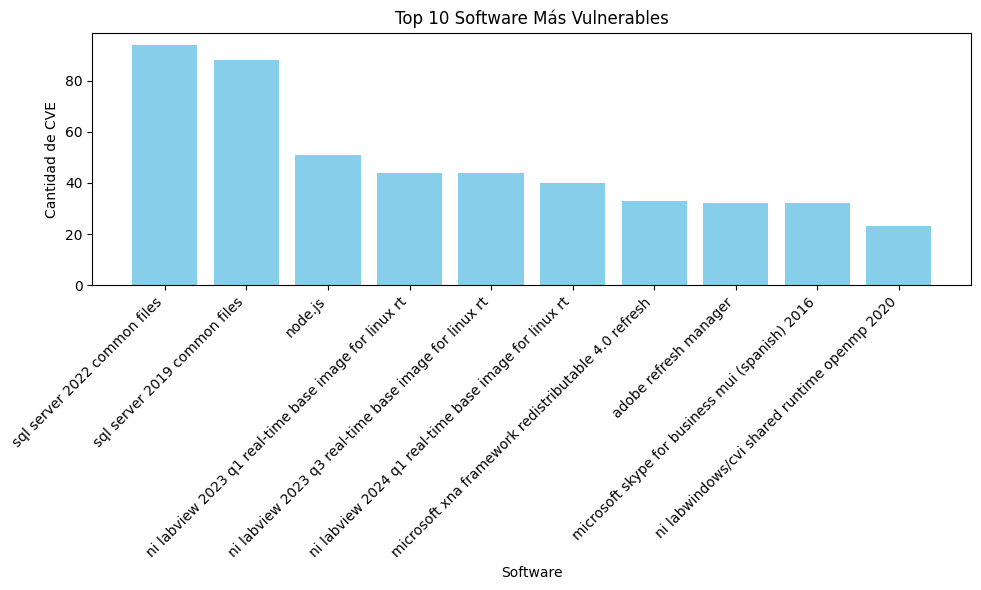

In [6]:
# Diccionario para almacenar el conjunto de CVE únicos por software
cve_sets = defaultdict(set)

# Iterar sobre los elementos en 'data' y agregar los CVE únicos por software a los conjuntos
for computer in data:
    for software_info in computer['softwares']:
        # Verificar si la clave 'software' existe y no es None antes de normalizar el nombre del software
        if 'software' in software_info and software_info['software'] is not None:
            # Normalizar el nombre del software convirtiéndolo a minúsculas y eliminando espacios adicionales
            software_name = software_info['software'].strip().lower()
            for vulnerability in software_info['vulnerabilities']:
                cve_sets[software_name].add(vulnerability['cve'])

# Diccionario para almacenar la cantidad de CVE por software
cve_counts = {software: len(cve_set) for software, cve_set in cve_sets.items()}

# Ordenar el diccionario por la cantidad de CVE en orden descendente
sorted_cve_counts = dict(sorted(cve_counts.items(), key=lambda item: item[1], reverse=True))

# Seleccionar los 10 primeros software más vulnerables
top_10_software = dict(list(sorted_cve_counts.items())[:10])

# Crear la gráfica de barras vertical
plt.figure(figsize=(10, 6))
plt.bar(list(top_10_software.keys()), list(top_10_software.values()), color='skyblue')
plt.xlabel('Software')
plt.ylabel('Cantidad de CVE')
plt.title('Top 10 Software Más Vulnerables')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones

exportTopSWBarChart(top_10_software, "topSoftware.html")

plt.show()

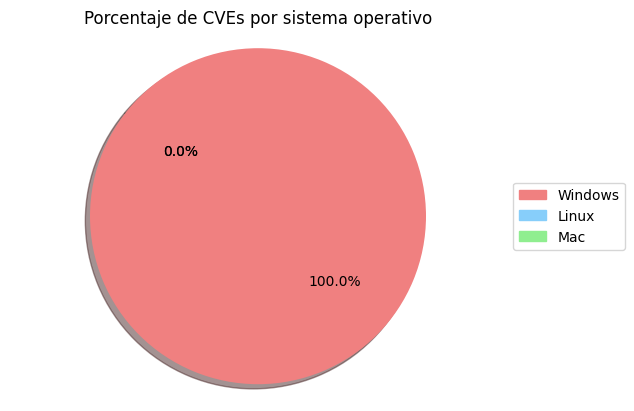

In [7]:
# Diccionario para almacenar los CVEs únicos por sistema operativo
cve_counts = {"Windows": set(), "Linux": set(), "Mac": set()}

# Iterar sobre los datos para contar los CVEs únicos y relacionarlos con el sistema operativo
for entry in data:
    os = entry["operativeSystem"]
    for software in entry["softwares"]:
        for vulnerability in software["vulnerabilities"]:
            cve_counts[os].add(vulnerability["cve"])

# Contar la cantidad total de CVEs únicos
total_cve = sum(len(cves) for cves in cve_counts.values())

# Calcular los porcentajes de CVEs por sistema operativo
percentages = {os: len(cves) / total_cve * 100 for os, cves in cve_counts.items()}

# Crear el gráfico de torta
labels = percentages.keys()
sizes = percentages.values()
colors = ['lightcoral', 'lightskyblue', 'lightgreen']
plt.pie(sizes, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Porcentaje de CVEs por sistema operativo')

# Convención de colores
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]
plt.legend(handles=patches, loc="center left", bbox_to_anchor=(1, 0.5))


plt.show()

In [8]:
def exportOSPieChart(data, fileName):
    # Convertir datos a formato compatible con Chart.js
    labels = list(data.keys())
    values = list(data.values())
    colors = ['lightcoral', 'lightskyblue', 'lightgreen']

    # Generar el código HTML con Chart.js
    html_code = f'''
        <!DOCTYPE html>
        <html lang="en">
        <head>
          <meta charset="UTF-8">
          <meta name="viewport" content="width=device-width, initial-scale=1.0">
          <title>SO más Vulnerables</title>
          <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
          <style>
            canvas{{ 
                -moz-user-select: none;
                -webkit-user-select: none;
                -ms-user-select: none;
            }}
          </style>
        </head>
        <body>
          <div style="width: 75%;">
            <canvas id="myChart"></canvas>
          </div>
          <script>
            var ctx = document.getElementById('myChart').getContext('2d');
            var myChart = new Chart(ctx, {{
                type: 'pie',
                data: {{
                    labels: {json.dumps(labels)},
                    datasets: [{{
                        data: {json.dumps(values)},
                        backgroundColor: {json.dumps(colors)}
                    }}]
                }},
                options: {{
                    responsive: true,
                    maintainAspectRatio: false,
                    title: {{
                        display: true,
                        text: 'Porcentaje de CVEs por sistema operativo'
                    }},
                    legend: {{
                        display: true,
                        position: 'right'
                    }}
                }}
            }});
          </script>
        </body>
        </html>
        '''

    # Obtener la carpeta de descargas del usuario actual
    downloads_dir = 'C:\\Users\\{USER}\\Downloads'

    # Crear la ruta completa de guardado
    savePath = downloads_dir + "\\" + fileName

    # Guardar el código HTML en un archivo
    with open(savePath, 'w', encoding='utf-8') as f:
        f.write(html_code)

    print(f"La gráfica ha sido guardada en: {savePath}")

In [9]:
# Diccionario para almacenar los CVEs únicos por sistema operativo
cve_counts = {"Windows": set(), "Linux": set(), "Mac": set()}

# Iterar sobre los datos para contar los CVEs únicos y relacionarlos con el sistema operativo
for entry in data:
    os = entry["operativeSystem"]
    for software in entry["softwares"]:
        for vulnerability in software["vulnerabilities"]:
            cve_counts[os].add(vulnerability["cve"])

# Contar la cantidad total de CVEs únicos
total_cve = sum(len(cves) for cves in cve_counts.values())

# Calcular los porcentajes de CVEs por sistema operativo
percentages = {os: len(cves) / total_cve for os, cves in cve_counts.items()}

# Convertir los porcentajes a cantidades absolutas de CVEs
total_data = {os: int(percent * total_cve) for os, percent in percentages.items()}

exportOSPieChart(total_data, "osVulnerabilities.html")

La gráfica ha sido guardada en: C:\Users\Yamid\Downloads\osVulnerabilities.html


In [10]:
def exportLineChart(data, fileName):
    # Extraer datos de las claves y valores
    labels = list(data.keys())
    values = list(data.values())

    # Generar el código HTML con Chart.js
    html_code = f'''
    <!DOCTYPE html>
    <html lang="en">
    <head>
      <meta charset="UTF-8">
      <meta name="viewport" content="width=device-width, initial-scale=1.0">
      <title>Diagrama de Líneas</title>
      <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
      <style>
        canvas{{ 
            -moz-user-select: none;
            -webkit-user-select: none;
            -ms-user-select: none;
        }}
      </style>
    </head>
    <body>
      <div style="width: 75%;">
        <canvas id="myChart"></canvas>
      </div>
      <script>
        var ctx = document.getElementById('myChart').getContext('2d');
        var myChart = new Chart(ctx, {{
            type: 'line',
            data: {{
                labels: {json.dumps(labels)},
                datasets: [{{
                    label: 'Frecuencia',
                    data: {json.dumps(values)},
                    fill: false,
                    borderColor: 'rgb(255, 99, 132)',  // Cambia el color aquí (en formato RGB)
                    tension: 0.1
                }}]
            }},
            options: {{
                responsive: true,
                maintainAspectRatio: false,
                title: {{
                    display: true,
                    text: 'Top 10 CVEs más repetidos'
                }},
                scales: {{
                    y: {{
                        beginAtZero: true
                    }}
                }}
            }}
        }});
      </script>
    </body>
    </html>
    '''

    # Obtener la carpeta de descargas del usuario actual
    downloads_dir = 'C:\\Users\\{USER}\\Downloads'

    # Crear la ruta completa de guardado
    savePath = downloads_dir + "\\" + fileName

    with open(savePath, 'w', encoding='utf-8') as f:
        f.write(html_code)

    print(f"La gráfica ha sido guardada en: {savePath}")

La gráfica ha sido guardada en: C:\Users\Yamid\Downloads\mostCVE.html


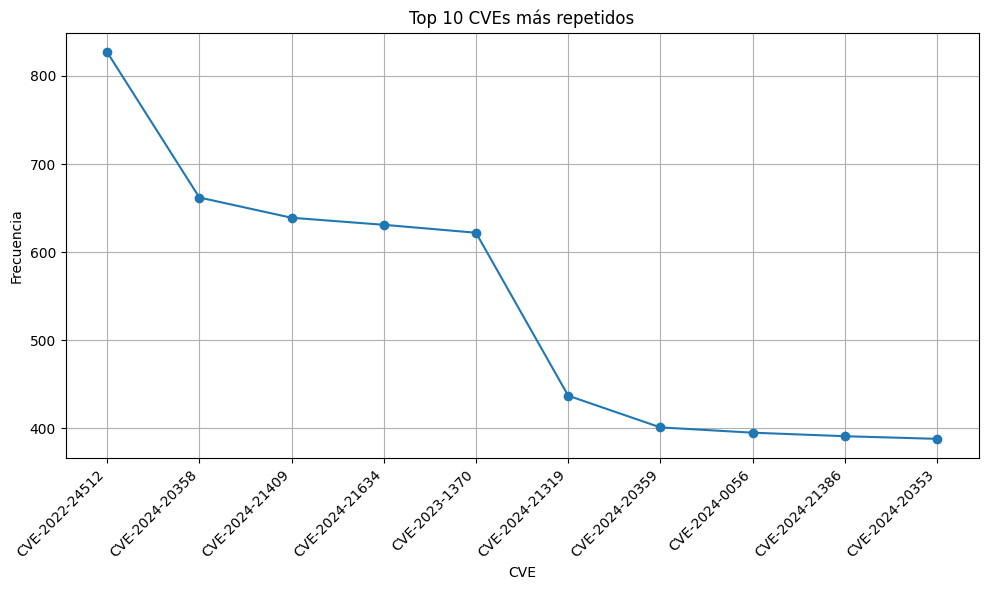

In [11]:
# Contar la frecuencia de cada CVE
cve_frequency = {}
for entry in data:
    for software in entry["softwares"]:
        for vulnerability in software["vulnerabilities"]:
            cve = vulnerability["cve"]
            cve_frequency[cve] = cve_frequency.get(cve, 0) + 1

# Seleccionar los 10 CVE más comunes
top_10_cves = sorted(cve_frequency, key=cve_frequency.get, reverse=True)[:10]

# Obtener las frecuencias de los 10 CVE más comunes
frequencies = [cve_frequency[cve] for cve in top_10_cves]

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(top_10_cves, frequencies, marker='o', linestyle='-')
plt.title('Top 10 CVEs más repetidos')
plt.xlabel('CVE')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

exportLineChart(dict(zip(top_10_cves, frequencies)), "mostCVE.html")

plt.show()

In [12]:
# Diccionario para almacenar la cantidad de CVE distintos por nivel de severidad
cve_counts = {
    "LOW": set(),
    "MEDIUM": set(),
    "HIGH": set(),
    "CRITICAL": set()
}

# Recorrer los datos para contar los CVE distintos por nivel de severidad
for entry in data:
    for software in entry["softwares"]:
        for vulnerability in software["vulnerabilities"]:
            cve = vulnerability["cve"]
            severity = vulnerability["metrics"]["baseSeverity"]
            if severity in cve_counts:
                cve_counts[severity].add(cve)

# Imprimir la cantidad de CVE distintos por nivel de severidad
for severity, cve_set in cve_counts.items():
    print(f"Nivel de severidad: {severity}, Cantidad de CVE distintos: {len(cve_set)}")

Nivel de severidad: LOW, Cantidad de CVE distintos: 32
Nivel de severidad: MEDIUM, Cantidad de CVE distintos: 336
Nivel de severidad: HIGH, Cantidad de CVE distintos: 268
Nivel de severidad: CRITICAL, Cantidad de CVE distintos: 75


In [13]:
def exportHorizontalBarChart(pc_names, cve_counts, colors, fileName):
    # Generar el código HTML con Chart.js
    html_code = f'''
    <!DOCTYPE html>
    <html lang="en">
    <head>
      <meta charset="UTF-8">
      <meta name="viewport" content="width=device-width, initial-scale=1.0">
      <title>Cantidad de CVEs por PC</title>
      <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
      <style>
        canvas{{ 
            -moz-user-select: none;
            -webkit-user-select: none;
            -ms-user-select: none;
        }}
      </style>
    </head>
    <body>
      <div style="width: 75%;">
        <canvas id="myChart"></canvas>
      </div>
      <script>
        var ctx = document.getElementById('myChart').getContext('2d');
        var myChart = new Chart(ctx, {{
            type: 'bar',
            data: {{
                labels: {json.dumps(pc_names)},
                datasets: [{{
                    label: 'Cantidad de CVEs',
                    data: {json.dumps(cve_counts)},
                    backgroundColor: {json.dumps(colors)}
                }}]
            }},
            options: {{
                responsive: true,
                maintainAspectRatio: false,
                title: {{
                    display: true,
                    text: 'Cantidad de CVEs por PC'
                }},
                scales: {{
                    y: {{
                        beginAtZero: true
                    }}
                }}
            }}
        }});
      </script>
    </body>
    </html>
    '''

   # Obtener la carpeta de descargas del usuario actual
    downloads_dir = 'C:\\Users\\{USER}\\Downloads'

    # Crear la ruta completa de guardado
    savePath = downloads_dir + "\\" + fileName

    with open(savePath, 'w', encoding='utf-8') as f:
        f.write(html_code)

    print(f"La gráfica ha sido guardada en: {savePath}")

La gráfica ha sido guardada en: C:\Users\Yamid\Downloads\vulnerablePC.html


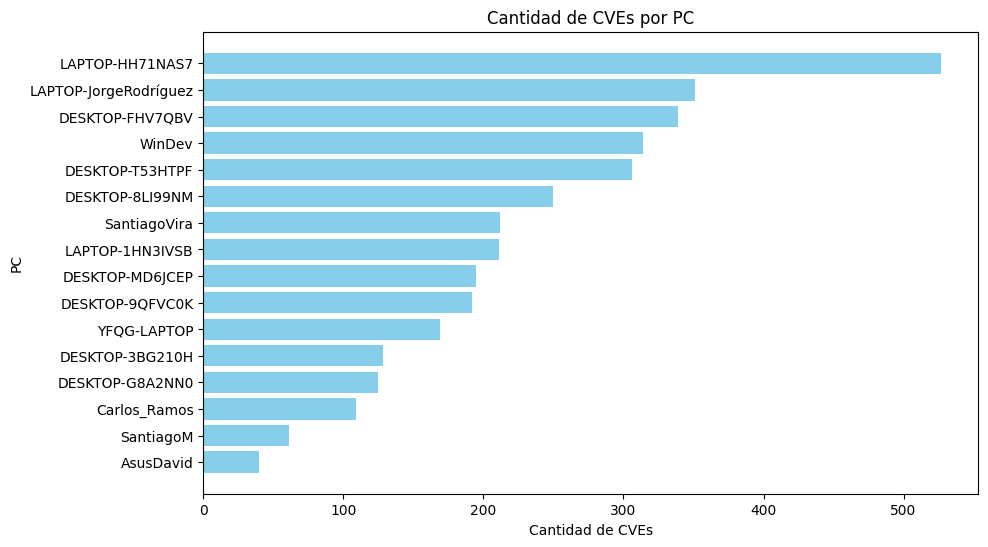

In [14]:
# Contar la cantidad de CVEs únicos por PC
pc_cve_counts = {}

for entry in data:
    pc = entry["pc"]
    cve_set = set()
    for software in entry["softwares"]:
        for vulnerability in software["vulnerabilities"]:
            cve_set.add(vulnerability["cve"])
    pc_cve_counts[pc] = len(cve_set)

# Ordenar los resultados de mayor a menor
sorted_pc_cve_counts = dict(sorted(pc_cve_counts.items(), key=lambda item: item[1], reverse=True))

# Extraer los nombres de los PCs y sus respectivas cantidades de CVEs
pc_names = list(sorted_pc_cve_counts.keys())
cve_counts = list(sorted_pc_cve_counts.values())
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'lightcoral', 'lightskyblue', 'lightgreen', 'skyblue', 'salmon', 'lightgreen', 'orange', 'lightcoral', 'lightskyblue', 'lightgreen', 'skyblue', 'salmon']

# Crear la gráfica de barras horizontal
plt.figure(figsize=(10, 6))
plt.barh(pc_names, cve_counts, color='skyblue')
plt.xlabel('Cantidad de CVEs')
plt.ylabel('PC')
plt.title('Cantidad de CVEs por PC')
plt.gca().invert_yaxis()  # Invertir el eje y para que el PC con más CVEs esté arriba

exportHorizontalBarChart(pc_names, cve_counts, colors, "vulnerablePC.html")

plt.show()

In [15]:
def exportSeverityPieChart(severity_counts, fileName):
    # Convertir datos a formato compatible con Chart.js
    labels = list(severity_counts.keys())
    values = list(severity_counts.values())
    colors = ['yellow','red', 'green', 'purple', 'blue']

    # Generar el código HTML con Chart.js
    html_code = f'''
    <!DOCTYPE html>
    <html lang="en">
    <head>
      <meta charset="UTF-8">
      <meta name="viewport" content="width=device-width, initial-scale=1.0">
      <title>Distribución de CVEs por Severidad</title>
      <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
      <style>
        canvas{{ 
            -moz-user-select: none;
            -webkit-user-select: none;
            -ms-user-select: none;
        }}
      </style>
    </head>
    <body>
      <div style="width: 75%;">
        <canvas id="myChart"></canvas>
      </div>
      <script>
        var ctx = document.getElementById('myChart').getContext('2d');
        var myChart = new Chart(ctx, {{
            type: 'pie',
            data: {{
                labels: {json.dumps(labels)},
                datasets: [{{
                    data: {json.dumps(values)},
                    backgroundColor: {json.dumps(colors)}
                }}]
            }},
            options: {{
                responsive: true,
                maintainAspectRatio: false,
                title: {{
                    display: true,
                    text: 'Distribución de CVEs por Severidad'
                }}
            }}
        }});
      </script>
    </body>
    </html>
    '''
    # Obtener la carpeta de descargas del usuario actual
    downloads_dir = 'C:\\Users\\{USER}\\Downloads'

    # Crear la ruta completa de guardado
    savePath = downloads_dir + "\\" + fileName

    with open(savePath, 'w', encoding='utf-8') as f:
        f.write(html_code)

    print(f"La gráfica ha sido guardada en: {savePath}")

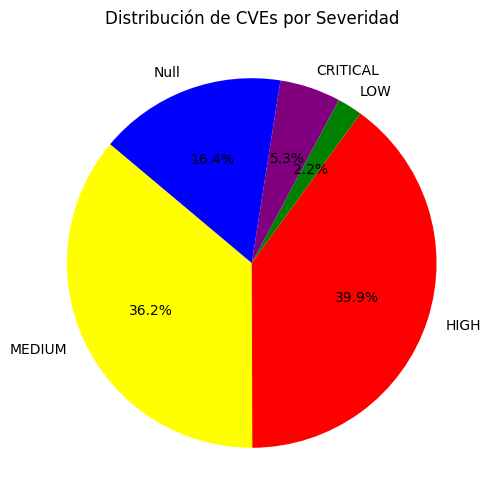

La gráfica ha sido guardada en: C:\Users\Yamid\Downloads\severityPie.html


In [16]:
# Diccionario para contar los CVEs por baseSeverity
severity_counts = defaultdict(int)

# Procesar los datos
for computer in data:
    for software in computer['softwares']:
        for vulnerability in software['vulnerabilities']:
            severity = vulnerability['metrics']['baseSeverity']
            severity_counts[severity] += 1

# Crear la gráfica de torta para la cantidad de CVEs por baseSeverity
labels = severity_counts.keys()
sizes = severity_counts.values()
colors = ['yellow','red', 'green', 'purple', 'blue']

plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribución de CVEs por Severidad')
plt.show()

exportSeverityPieChart(severity_counts, "severityPie.html")

In [17]:
def exportYearLineChart(year_counts, fileName):
    # Convertir datos a formato compatible con Chart.js
    years = sorted(year_counts.keys())
    counts = [year_counts[year] for year in years]

    # Generar el código HTML con Chart.js
    html_code = f'''
    <!DOCTYPE html>
    <html lang="en">
    <head>
      <meta charset="UTF-8">
      <meta name="viewport" content="width=device-width, initial-scale=1.0">
      <title>Distribución de CVEs por Año</title>
      <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
      <style>
        canvas{{ 
            -moz-user-select: none;
            -webkit-user-select: none;
            -ms-user-select: none;
        }}
      </style>
    </head>
    <body>
      <div style="width: 75%; height: 500px;">
        <canvas id="myChart"></canvas>
      </div>
      <script>
        var config = {{
            type: 'line',
            data: {{
                labels: {json.dumps(years)},
                datasets: [{{
                    label: 'Cantidad de CVEs',
                    data: {json.dumps(counts)},
                    borderColor: 'blue',
                    backgroundColor: 'rgba(0, 0, 255, 0.1)',
                    fill: true,
                    tension: 0.1,
                    pointStyle: 'circle',
                    pointRadius: 5,
                    pointHoverRadius: 7
                }}]
            }},
            options: {{
                responsive: true,
                maintainAspectRatio: false,
                title: {{
                    display: true,
                    text: 'Distribución de CVEs por Año'
                }},
                scales: {{
                    x: {{
                        title: {{
                            display: true,
                            text: 'Año'
                        }}
                    }},
                    y: {{
                        beginAtZero: true,
                        title: {{
                            display: true,
                            text: 'Cantidad de CVEs'
                        }}
                    }}
                }},
                plugins: {{
                    tooltip: {{
                        callbacks: {{
                            label: function(context) {{
                                return ' ' + context.raw + ' CVEs';
                            }}
                        }}
                    }}
                }}
            }}
        }};

        var ctx = document.getElementById('myChart').getContext('2d');
        var myChart = new Chart(ctx, config);
      </script>
    </body>
    </html>
    '''

    # Obtener la carpeta de descargas del usuario actual
    downloads_dir = 'C:\\Users\\{USER}\\Downloads'

    # Crear la ruta completa de guardado
    savePath = downloads_dir + "\\" + fileName

    with open(savePath, 'w', encoding='utf-8') as f:
        f.write(html_code)

    print(f"La gráfica ha sido guardada en: {savePath}")

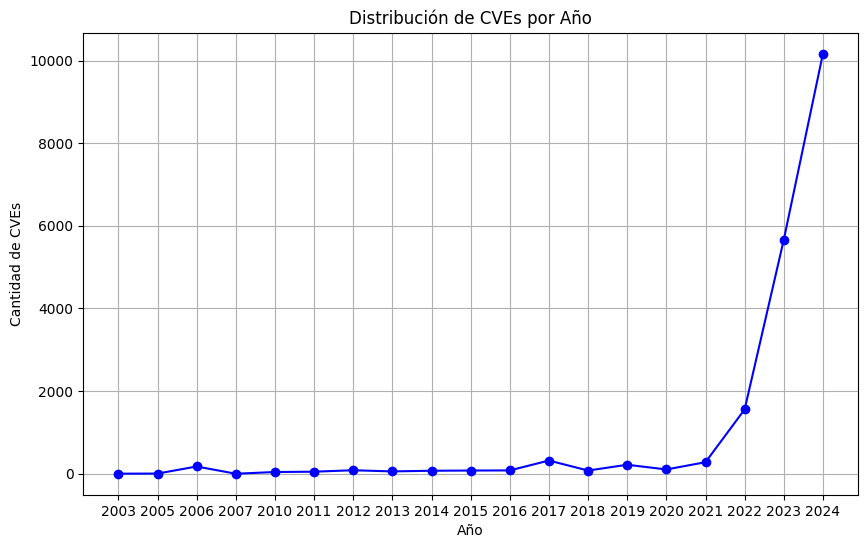

La gráfica ha sido guardada en: C:\Users\Yamid\Downloads\yearLine.html


In [18]:
# Diccionario para contar los CVEs por año
year_counts = defaultdict(int)

# Procesar los datos
for computer in data:
    for software in computer['softwares']:
        for vulnerability in software['vulnerabilities']:
            cve = vulnerability['cve']
            
            # Extraer el año del CVE
            match = re.match(r"CVE-(\d{4})-", cve)
            if match:
                year = match.group(1)
                year_counts[year] += 1

# Crear la gráfica de líneas para la distribución de CVEs por año
years = sorted(year_counts.keys())
counts = [year_counts[year] for year in years]

plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Cantidad de CVEs')
plt.title('Distribución de CVEs por Año')
plt.grid(True)
plt.show()

exportYearLineChart(year_counts, "yearLine.html")